Random Forest Round-by-Round Model with Professional Hyperparameter Tuning

1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import dump

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')


2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]
file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 23-24.csv"
df = pd.read_csv(file_path, usecols=usecols)

df['MatchIndex'] = df.index + 1
df['Round']      = np.ceil(df['MatchIndex'] / 10).astype(int)

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

print("Loaded shape:", df.shape)


Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# 3.1 Targets
df['Outcome']  = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5']  = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2 Implied probabilities from odds
for side in ['H','D','A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5','ImpUnder2.5']] = (
    df[['ImpOver2.5','ImpUnder2.5']]
      .div(df[['ImpOver2.5','ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Odds spread
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/Loss streaks
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: 
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: 
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# 3.6 Interaction
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins','RefMatches'], inplace=True)

# 3.8 Head-to-head last result
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# 3.9 Rolling averages of match stats
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']
for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )
for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# 3.10 Previous-round table positions
df['HomePts'] = np.where(df['FTR']=='H', 3, np.where(df['FTR']=='D', 1, 0))
df['AwayPts'] = np.where(df['FTR']=='A', 3, np.where(df['FTR']=='D', 1, 0))

pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],   df['AwayPts']])
})
round_pts = (
    pts
    .groupby(['Team','Round'], as_index=False)['Pts']
    .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos']    = (
    round_pts
    .groupby('Round')['CumPts']
    .rank(method='min', ascending=False)
)
prev = round_pts[['Team','Round','Pos']].copy()
prev.rename(columns={'Round':'PrevRound','Pos':'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

df = df.merge(
    prev, left_on=['HomeTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(
    prev, left_on=['AwayTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)


4. Pipeline Specification & Hyperparameter Distributions

In [4]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint

# 4.1) Safety: ensure feature lists (if earlier cell didn't run)
if 'cat_feats' not in globals() or 'num_feats' not in globals():
    cat_feats = [c for c in ['HomeTeam','AwayTeam','Referee','TimeOfDay'] if c in df.columns]
    base_num = [
        'ImpProb_H','ImpProb_D','ImpProb_A',
        'ImpOver2.5','ImpUnder2.5','OddsSpread','Spread×Form',
        'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
        'RefBias','H2H_Last','HomePosPrev','AwayPosPrev',
        'Home_HS_3','Home_HST_3','Home_HF_3','Home_HC_3','Home_HY_3','Home_HR_3',
        'Away_AS_3','Away_AST_3','Away_AF_3','Away_AC_3','Away_AY_3','Away_AR_3'
    ]
    num_feats = [c for c in base_num if c in df.columns]

# 4.2) RF-specific preprocessing (no z-score; dense OHE)
rf_cat = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', min_frequency=2, sparse_output=False))
])
rf_num = Pipeline([
    ('imp', SimpleImputer(strategy='median'))
])

rf_pre = ColumnTransformer(
    transformers=[
        ('cat', rf_cat, cat_feats),
        ('num', rf_num, num_feats)
    ],
    sparse_threshold=0.0
)

# 4.3) RF model factory (stable defaults)
def make_rf():
    return Pipeline([
        ('prep', rf_pre),
        ('clf', RandomForestClassifier(
            n_estimators=1000,
            max_depth=None,
            min_samples_leaf=12,
            max_features='sqrt',
            class_weight='balanced_subsample',
            bootstrap=True,
            n_jobs=-1,
            random_state=42
        ))
    ])

# 4.4) Time-series CV + compact randomized search space
tscv = TimeSeriesSplit(n_splits=3)
rf_space = {
    'clf__n_estimators': randint(800, 1300),
    'clf__max_depth': [None, 12, 14, 16, 18, 20],
    'clf__min_samples_leaf': randint(8, 20),
    'clf__max_features': ['sqrt', 0.6, 0.7, 0.8],
    # optional speed/variance trade-off:
    # 'clf__max_samples': [0.8, 0.85, 0.9]
}

def make_rf_search():
    return RandomizedSearchCV(
        estimator=make_rf(),
        param_distributions=rf_space,
        n_iter=25,
        cv=tscv,
        scoring='accuracy',   # accuracy-only as requested
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

# 4.5) Utility: reorder probability columns to a fixed label order [-1, 0, 1]
import numpy as np
def reorder_proba_cols(P: np.ndarray, classes_: np.ndarray, target_order=[-1,0,1]) -> np.ndarray:
    order = {c:i for i,c in enumerate(classes_)}
    idx = [order[c] for c in target_order]
    return P[:, idx]


5. Round-by-Round Training & Prediction with Tuning

In [5]:
from sklearn.metrics import accuracy_score

# 5.1) Containers for global results
preds, actuals, rounds, match_indices = [], [], [], []

# 5.2) Warm-up (first 5 rounds): quick fit to ensure preprocessors see initial categories
WARMUP_ROUNDS  = 5
WARMUP_MATCHES = WARMUP_ROUNDS * 10

X_warm = df.loc[:WARMUP_MATCHES-1, cat_feats + num_feats]
y_warm = df.loc[:WARMUP_MATCHES-1, 'Outcome']
_ = make_rf().fit(X_warm, y_warm)

# 5.3) Predict from round 6 onward (exactly 10 matches per round)
max_round = int(df['Round'].max())

for r in range(WARMUP_ROUNDS + 1, max_round + 1):
    train_mask = df['Round'] < r
    test_mask  = df['Round'] == r

    # test slice (force exactly 10 matches)
    round_df = df.loc[test_mask, :].sort_values(['Round','MatchIndex'])
    if len(round_df) > 10:
        round_df = round_df.head(10)
        test_mask = df.index.isin(round_df.index)
    if len(round_df) < 10:
        print(f"Round {r}: only {len(round_df)} matches available → skipped.")
        continue

    # validation = last full round r-1 if available, else last 10% fallback
    val_mask = (df['Round'] == (r - 1)) & train_mask
    if val_mask.sum() < 10:
        tr_sorted = df.loc[train_mask, :].sort_values(['Round','MatchIndex']).index
        split = int(len(tr_sorted) * 0.9)
        val_mask = df.index.isin(tr_sorted[split:])
        train_mask = df.index.isin(tr_sorted[:split])
    else:
        train_mask = train_mask & (~val_mask)

    # build sets
    X_train = df.loc[train_mask, cat_feats + num_feats]
    y_train = df.loc[train_mask, 'Outcome']
    X_test  = df.loc[test_mask,  cat_feats + num_feats]
    y_test  = df.loc[test_mask,  'Outcome']

    # hyperparameter search (time-series CV; no leakage)
    rs = make_rf_search()
    rs.fit(X_train, y_train)
    model = rs.best_estimator_

    # predict exactly 10 matches
    P_test = model.predict_proba(X_test)
    P_test = reorder_proba_cols(P_test, model.named_steps['clf'].classes_, target_order=[-1,0,1])
    y_pred = np.array([-1,0,1])[P_test.argmax(axis=1)]

    # collect results
    preds.extend(y_pred.tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_pred))
    match_indices.extend(round_df['MatchIndex'].tolist())

    # per-round accuracy + log best params
    acc = accuracy_score(y_test, y_pred)
    print(f"Round {r}: 10 matches | accuracy = {acc:.3f} | RF best: {rs.best_params_}")

print(f"Predicted rounds {WARMUP_ROUNDS + 1}–{max_round} (10 matches each)")

# 5.4) Expose final trained pipeline (last round) and last training round
final_model = model
last_train_round = max_round - 1


Round 6: 10 matches | accuracy = 0.500 | RF best: {'clf__max_depth': 16, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 8, 'clf__n_estimators': 1259}
Round 7: 10 matches | accuracy = 0.500 | RF best: {'clf__max_depth': 16, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 8, 'clf__n_estimators': 1259}
Round 8: 10 matches | accuracy = 0.600 | RF best: {'clf__max_depth': 16, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 8, 'clf__n_estimators': 1259}
Round 9: 10 matches | accuracy = 0.600 | RF best: {'clf__max_depth': 16, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 8, 'clf__n_estimators': 1259}
Round 10: 10 matches | accuracy = 0.500 | RF best: {'clf__max_depth': 16, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 8, 'clf__n_estimators': 1259}
Round 11: 10 matches | accuracy = 0.200 | RF best: {'clf__max_depth': 14, 'clf__max_features': 0.6, 'clf__min_samples_leaf': 8, 'clf__n_estimators': 1219}
Round 12: 10 matches | accuracy = 0.500 | RF best: {'clf__m

6. Assemble, Save Results & Final Model

In [6]:
# 6.1 Assemble DataFrame of predictions
df_idx = df.set_index('MatchIndex')
homes = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
aways = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':       rounds,
    'HomeTeam':    homes,
    'AwayTeam':    aways,
    'Actual':      actuals,
    'Predicted':   preds
})

label_map = {1: 'H', 0: 'D', -1: 'A'}
results_df['ActualLabel'] = results_df['Actual'].map(label_map)
results_df['PredLabel']   = results_df['Predicted'].map(label_map)

# 6.2 Save predictions to Excel
output_path = r"D:\python\premier league predictor\rf_predictions_vs_actuals.xlsx"
results_df.to_excel(output_path, index=False)
print("Results written to", output_path)

# 6.3 Save final trained pipeline
dump(model, r"D:\python\premier league predictor\rf_pl_pipeline.joblib")
print("Final Random Forest pipeline saved.")


Results written to D:\python\premier league predictor\rf_predictions_vs_actuals.xlsx
Final Random Forest pipeline saved.


7. Results & Visualization

Overall accuracy (rounds 6–38): 0.555


C:\Users\markf\AppData\Local\Temp\ipykernel_1784\3158466751.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g['Actual'], g['Pred']))


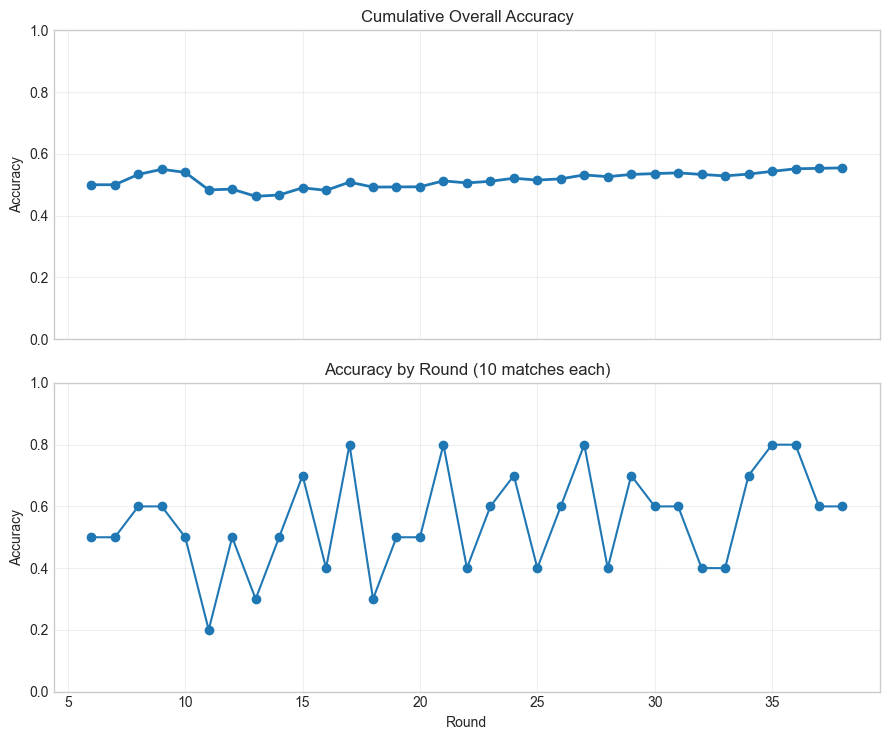

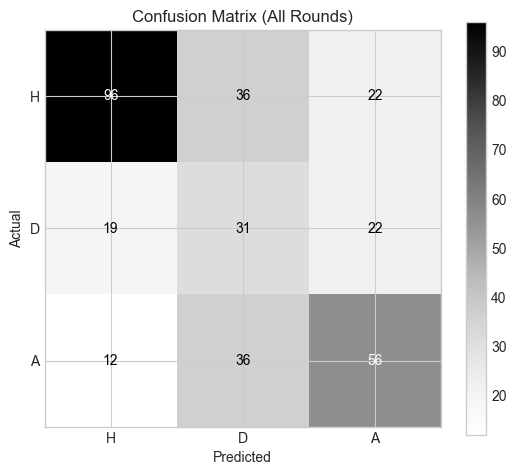

Saved: rf_accuracy_by_round.csv


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# 7.1 Overall accuracy (text)
overall_acc = accuracy_score(actuals, preds)
print(f"Overall accuracy (rounds {WARMUP_ROUNDS + 1}–{max_round}): {overall_acc:.3f}")

# 7.2 Build ordered results frame
res_df = pd.DataFrame({'Round': rounds, 'Pred': preds, 'Actual': actuals}).sort_values('Round')

# 7.3 Per-round accuracy + cumulative overall accuracy (weighted by matches)
acc_by_round = (
    res_df.groupby('Round')
          .apply(lambda g: accuracy_score(g['Actual'], g['Pred']))
          .reset_index(name='Accuracy')
          .sort_values('Round')
)

res_df['Correct'] = (res_df['Pred'] == res_df['Actual']).astype(int)
agg = (res_df.groupby('Round')
              .agg(CorrectCount=('Correct','sum'), N=('Correct','size'))
              .reset_index()
              .sort_values('Round'))
agg['CumCorrect'] = agg['CorrectCount'].cumsum()
agg['CumTotal']   = agg['N'].cumsum()
agg['CumAcc']     = agg['CumCorrect'] / agg['CumTotal']

# 7.4 Plots: cumulative (top) + per-round (bottom) — classic layout
fig, axes = plt.subplots(2, 1, figsize=(9, 7.5), sharex=True)

axes[0].plot(agg['Round'], agg['CumAcc'], marker='o', linewidth=2)
axes[0].set_title('Cumulative Overall Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0.0, 1.0)
axes[0].grid(True, alpha=0.3)

axes[1].plot(acc_by_round['Round'], acc_by_round['Accuracy'], marker='o')
axes[1].set_title('Accuracy by Round (10 matches each)')
axes[1].set_xlabel('Round')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7.5 Confusion matrix (H, D, A) — heatmap with counts
label_order = [1, 0, -1]  # Home, Draw, Away
label_to_str = {1:'H', 0:'D', -1:'A'}
cm = confusion_matrix(actuals, preds, labels=label_order)

plt.figure(figsize=(5.6, 4.8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (All Rounds)')
plt.colorbar()
tick_marks = np.arange(len(label_order))
plt.xticks(tick_marks, [label_to_str[x] for x in label_order])
plt.yticks(tick_marks, [label_to_str[x] for x in label_order])
plt.xlabel('Predicted'); plt.ylabel('Actual')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.tight_layout()
plt.show()

# 7.6 (Optional) Save per-round accuracy to CSV
try:
    acc_by_round.to_csv('rf_accuracy_by_round.csv', index=False)
    print("Saved: rf_accuracy_by_round.csv")
except Exception as e:
    print(f"Could not save per-round accuracy CSV: {e}")


8. Gradio Interface

In [8]:
import gradio as gr
import pandas as pd
import numpy as np

# ----------------------------------------------------------------------------
# Precompute the training-set means of the odds-derived features:
# ----------------------------------------------------------------------------
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]
odd_means = df[odd_feats].mean()

# ----------------------------------------------------------------------------
# Gradio dropdown choices:
# ----------------------------------------------------------------------------
teams = sorted(df['HomeTeam'].unique())
refs  = sorted(df['Referee'].unique())
times = ['Morning','Afternoon','Evening']

# ----------------------------------------------------------------------------
# Prediction function
# ----------------------------------------------------------------------------
def predict_outcome(home_team, away_team, referee, time_of_day):
    # 1) Pull the last historical row for each entity
    home = df[df.HomeTeam == home_team].iloc[-1]
    away = df[df.AwayTeam == away_team].iloc[-1]
    ref  = df[df.Referee == referee].iloc[-1]
    
    # 2) Assemble the feature dict
    data = {}
    
    # 2a) Odds-derived features: fill with their training-set means
    for feat in odd_feats:
        data[feat] = odd_means[feat]
    
    # 2b) Rolling form & streaks
    data['HomeForm3']  = home['HomeForm3']
    data['AwayForm3']  = away['AwayForm3']
    data['HomeStreak'] = home['HomeStreak']
    data['AwayStreak'] = away['AwayStreak']
    
    # 2c) Interaction term
    data['Spread×Form'] = data['OddsSpread'] * data['HomeForm3']
    
    # 2d) Referee bias
    data['RefBias'] = ref['RefBias']
    
    # 2e) Head-to-head last
    pair = ((df.HomeTeam==home_team)&(df.AwayTeam==away_team)) | \
           ((df.HomeTeam==away_team)&(df.AwayTeam==home_team))
    data['H2H_Last'] = df[pair].iloc[-1]['H2H_Last']
    
    # 2f) Previous round positions
    data['HomePosPrev'] = home['HomePosPrev']
    data['AwayPosPrev'] = away['AwayPosPrev']
    
    # 2g) Rolling match-stats (shots, fouls, cards)
    for s in home_stats:
        data[f'Home_{s}_3'] = home[f'Home_{s}_3']
    for s in away_stats:
        data[f'Away_{s}_3'] = away[f'Away_{s}_3']
    
    # 2h) Categorical features
    data['HomeTeam']  = home_team
    data['AwayTeam']  = away_team
    data['Referee']   = referee
    data['TimeOfDay'] = time_of_day
    
    # 3) DataFrame and predict
    Xnew  = pd.DataFrame([data])
    probs = final_model.predict_proba(Xnew)[0]
    classes = list(final_model.classes_)  # e.g. [-1,0,1]
    
    return (
        float(probs[classes.index(1)] * 100),
        float(probs[classes.index(0)] * 100),
        float(probs[classes.index(-1)] * 100)
    )

# ----------------------------------------------------------------------------
# Launch Gradio interface
# ----------------------------------------------------------------------------
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(teams, label="Home Team"),
        gr.Dropdown(teams, label="Away Team"),
        gr.Dropdown(refs,  label="Referee"),
        gr.Dropdown(times, label="Time of Day"),
    ],
    outputs=[
        gr.Number(label="Home Win %", precision=1),
        gr.Number(label="Draw %",   precision=1),
        gr.Number(label="Away Win %" , precision=1)
    ],
    title="Premier League Outcome Predictor",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds-derived features are filled with their historical averages, "
        "all other features are pulled from past matches."
    )
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.
